In [1]:
import tensorflow as tf

# List available physical devices
physical_devices = tf.config.list_physical_devices()
print("Available devices:", physical_devices)

# Check for GPU specifically
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs available:", gpus)


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\tony_\OneDrive\Desktop\GP\DATASETS\modified dataset\6diseases",  # replace with your dataset directory
    image_size=(224, 224),  # Resize images to 224x224 (or any size)
    batch_size=32,         # batch_size=32,Load in batches of 32
    label_mode='categorical' # Labels can be 'int', 'categorical', or None
)

Found 17093 files belonging to 6 classes.


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Create empty lists to store the features and labels after extraction
all_features = []
all_labels = []

# Load pre-trained ResNet model (without the top classification layers)
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Iterate over the dataset in batches to extract features
for images, labels in dataset:
    # Preprocess the images for ResNet50
    images_preprocessed = preprocess_input(images.numpy())
    
    # Extract feature vectors using ResNet50
    features = model.predict(images_preprocessed)
    
    # Store the feature vectors and corresponding labels
    all_features.append(features)
    all_labels.append(labels.numpy())

# Concatenate all features and labels
X = np.concatenate(all_features)
Y = np.concatenate(all_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

1/1 [==============================] - 3s 3s/step
Training data shape: (13674, 2048), Training labels shape: (13674, 6)
Testing data shape: (3419, 2048), Testing labels shape: (3419, 6)


In [6]:

# Save training and testing data and labels
np.savez('train_data.npz', X_train6=X_train, y_train6=y_train)
np.savez('test_data.npz', X_test6=X_test, y_test6=y_test)


In [10]:
# Load the training data
train_data = np.load('train_data.npz')
X_train = train_data['X_train6']
y_train = train_data['y_train6']

# Load the testing data
test_data = np.load('test_data.npz')
X_test = test_data['X_test6']
y_test = test_data['y_test6']

# Concatenate the features and labels
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

In [7]:
from sklearn.manifold import TSNE



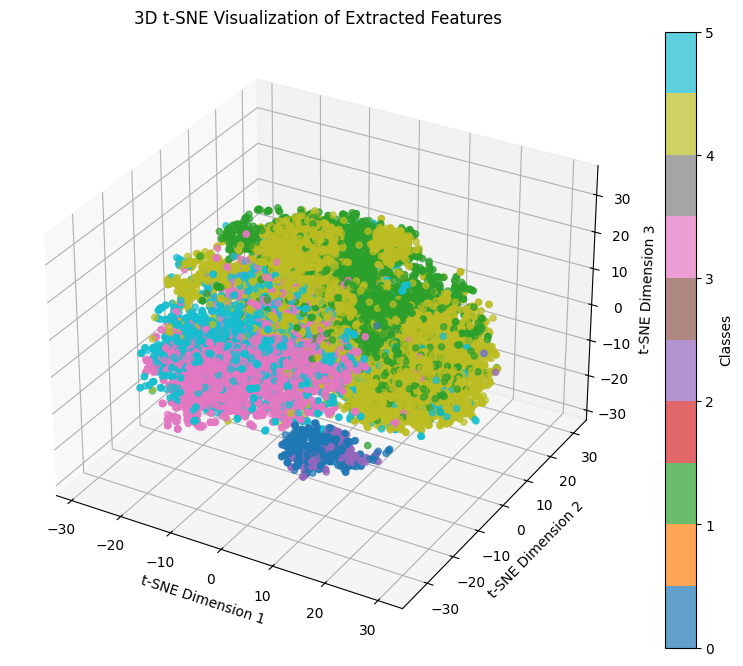

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE to reduce features to 3 dimensions
tsne = TSNE(n_components=3, random_state=42, perplexity=30, learning_rate=200)
X_embedded = tsne.fit_transform(X)

# Plot the 3D t-SNE representation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2],
                     c=np.argmax(Y, axis=1), cmap='tab10', alpha=0.7)
ax.set_title("3D t-SNE Visualization of Extracted Features")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")
plt.colorbar(scatter, label='Classes')
plt.show()


In [11]:
X_train = X_train / 224.0
X_test = X_test / 224.0

In [12]:
def print_unique_col_values(dataset):
    unique_labels = set()  # Create a set to collect unique labels
    for images, labels in dataset:
        # Convert labels to numpy and add unique label combinations to the set
        for label in labels.numpy():
            unique_labels.add(tuple(label))  # Convert to tuple for immutability
    print(f'Unique labels: {unique_labels}')


In [15]:
print_unique_col_values(dataset)

Unique labels: {(0.0, 0.0, 1.0, 0.0, 0.0, 0.0), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0)}


In [16]:
class_names = dataset.class_names
print("Class names:", class_names)

Class names: ['1. Eczema 1677', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624']


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming Y is one-hot encoded, convert it to class indices for easier processing
class_indices = np.argmax(Y, axis=1)

# Find indices of class 4 (melanocytic nevi)
class_4_indices = np.where(class_indices == 4)[0]

# Undersample class 4
desired_count = 3000  # Set your desired number of samples for class 
if len(class_4_indices) > desired_count:
    class_4_indices = np.random.choice(class_4_indices, size=desired_count, replace=False)

# Get features and labels for class 4
X_class_4 = X[class_4_indices]
y_class_4 = Y[class_4_indices]

# Find indices of other classes
other_indices = np.where(class_indices != 4)[0]

# Combine the samples
X_balanced = np.concatenate([X[other_indices], X_class_4], axis=0)
Y_balanced = np.concatenate([Y[other_indices], y_class_4], axis=0)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, Y_balanced, test_size=0.2, random_state=42)

print(f"Balanced training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Balanced testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Balanced training data shape: (9698, 2048), Training labels shape: (9698, 6)
Balanced testing data shape: (2425, 2048), Testing labels shape: (2425, 6)


In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

def oversample_classes_and_combine(X_train, X_test, y_train, y_test, X, Y, target_counts=None, test_size=0.2, random_state=42):
    """
    Function to oversample specified classes to reach target counts, split into training and testing sets, 
    and combine with existing X_train, X_test, y_train, y_test.
    
    Args:
    - X_train, X_test, y_train, y_test: Existing train-test data.
    - X: Full feature matrix (before train-test split).
    - Y: One-hot encoded labels.
    - target_counts: Dictionary specifying desired number of samples for each class (e.g., {0: 3000, 3: 3000, 5: 3000}).
    - test_size: Proportion of the dataset to include in the test split (default 0.2).
    - random_state: Random seed for reproducibility (default 42).
    
    Returns:
    - Updated X_train, X_test, y_train, y_test with oversampled data combined.
    """
    
    if target_counts is None:
        target_counts = {0: 3000, 2: 3000, 5:3000}  # Default target counts if not specified
    
    # Convert one-hot encoded labels to class indices for easier processing
    print("Converting one-hot encoded labels to class indices...")
    class_indices = np.argmax(Y, axis=1)
    
    # Initialize lists to hold combined data
    X_combined = X_train.copy()
    y_combined = y_train.copy()
    
    # Check the unique classes in the dataset
    unique_classes = np.unique(class_indices)
    print(f"Unique classes found in the dataset: {unique_classes}")

    for class_label, target_count in target_counts.items():
        print(f"Finding indices of class {class_label}...")
        class_indices_for_label = np.where(class_indices == class_label)[0]
        print(f"Found {len(class_indices_for_label)} samples for class {class_label}.")
        
        # Check if we have samples for the current class
        if len(class_indices_for_label) == 0:
            print(f"No samples found for class {class_label}. Skipping oversampling for this class.")
            continue
        
        # Get features and labels for the current class
        X_class = X[class_indices_for_label]
        y_class = Y[class_indices_for_label]
        
        # Determine how many additional samples are needed to reach the target count
        additional_samples_needed = target_count - len(class_indices_for_label)
        
        # If additional samples are needed, randomly replicate samples of the current class
        if additional_samples_needed > 0:
            print(f"Replicating class {class_label} samples to reach {target_count} samples...")
            replicated_indices = np.random.choice(class_indices_for_label, size=additional_samples_needed, replace=True)
            X_class = np.concatenate([X_class, X[replicated_indices]], axis=0)
            y_class = np.concatenate([y_class, Y[replicated_indices]], axis=0)
        
        # Split the oversampled class data into training and testing sets
        print(f"Splitting the oversampled class {class_label} data into training and testing sets...")
        X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
            X_class, y_class, test_size=test_size, random_state=random_state)
        
        # Combine the oversampled class data with the existing training data
        print(f"Combining oversampled class {class_label} data with existing training sets...")
        X_combined = np.concatenate([X_combined, X_class_train], axis=0)
        y_combined = np.concatenate([y_combined, y_class_train], axis=0)

        # Combine the test data, ensuring y_class_test is converted to 1D
        y_class_test_1d = np.argmax(y_class_test, axis=1)  # Convert to class indices
        X_test_combined = np.concatenate([X_test, X_class_test], axis=0)
        
        # Convert y_test to 1D if it's not already
        if y_test.ndim == 2:
            y_test_1d = np.argmax(y_test, axis=1)  # Convert to class indices
        else:
            y_test_1d = y_test
        
        y_test_combined = np.concatenate([y_test_1d, y_class_test_1d], axis=0)
    
    # Print shapes of the resulting datasets
    print(f"Updated training data shape: {X_combined.shape}, Training labels shape: {y_combined.shape}")
    print(f"Updated testing data shape: {X_test_combined.shape}, Testing labels shape: {y_test_combined.shape}")
    
    return X_combined, X_test_combined, y_combined, y_test_combined

# Example usage (after your undersampling ):
target_counts = {0: 3000, 2: 3000, 5:1000}  # Specify target counts for each class
X_train_updated, X_test_updated, y_train_updated, y_test_updated = oversample_classes_and_combine(
    X_train, X_test, y_train, y_test, X, Y, target_counts=target_counts
)


Converting one-hot encoded labels to class indices...
Unique classes found in the dataset: [0 1 2 3 4 5]
Finding indices of class 0...
Found 347 samples for class 0.
Replicating class 0 samples to reach 3000 samples...
Splitting the oversampled class 0 data into training and testing sets...
Combining oversampled class 0 data with existing training sets...
Finding indices of class 2...
Found 234 samples for class 2.
Replicating class 2 samples to reach 3000 samples...
Splitting the oversampled class 2 data into training and testing sets...
Combining oversampled class 2 data with existing training sets...
Finding indices of class 5...
Found 2079 samples for class 5.
Splitting the oversampled class 5 data into training and testing sets...
Combining oversampled class 5 data with existing training sets...
Updated training data shape: (16161, 2048), Training labels shape: (16161, 6)
Updated testing data shape: (2841, 2048), Testing labels shape: (2841,)


In [15]:
# Save training and testing data and labels after balancing
np.savez('train_data_updated.npz', X_train_updated6=X_train_updated, y_train_updated6=y_train_updated)
np.savez('test_data_updated.npz', X_test_updated6=X_test_updated, y_test_updated6=y_test_updated)


In [6]:
# Load training data
train_data = np.load('train_data_updated.npz')
X_train_updated = train_data['X_train_updated6']
y_train_updated = train_data['y_train_updated6']

# Load testing data
test_data = np.load('test_data_updated.npz')
X_test_updated = test_data['X_test_updated6']
y_test_updated = test_data['y_test_updated6']

# Verify shapes
print("X_train shape:", X_train_updated.shape)
print("y_train shape:", y_train_updated.shape)
print("X_test shape:", X_test_updated.shape)
print("y_test shape:", y_test_updated.shape)

X_train shape: (14498, 2048)
y_train shape: (14498, 6)
X_test shape: (3025, 2048)
y_test shape: (3025,)


In [19]:
import numpy as np

def print_class_counts(Y, dataset_name="Dataset"):
    """
    Function to print the count of each class in the dataset.
    
    Args:
    - Y: One-hot encoded labels or class indices.
    - dataset_name: Name of the dataset to print (e.g., "Training Set", "Test Set").
    """
    # Check if Y is one-hot encoded or a 1D array of class indices
    if Y.ndim == 2:  # If it's a one-hot encoded matrix
        class_indices = np.argmax(Y, axis=1)
    elif Y.ndim == 1:  # If it's already a 1D array of class indices
        class_indices = Y
    else:
        raise ValueError("Invalid shape for Y: it must be either one-hot encoded (2D) or class indices (1D).")
    
    # Count occurrences of each class
    class_counts = np.bincount(class_indices)
    
    # Print the class counts
    print(f"Class counts in {dataset_name}:")
    for class_index, count in enumerate(class_counts):
        print(f"Class {class_index}: {count} samples")

# Example usage for the training and testing sets:
print("Shape of y_train_updated:", y_train_updated.shape)
print("Shape of y_test_updated:", y_test_updated.shape)

print_class_counts(y_train_updated, dataset_name="Training Set")
print_class_counts(y_test_updated, dataset_name="Test Set")


Shape of y_train_updated: (16161, 6)
Shape of y_test_updated: (2841,)
Class counts in Training Set:
Class 0: 2690 samples
Class 1: 2522 samples
Class 2: 2593 samples
Class 3: 2654 samples
Class 4: 2389 samples
Class 5: 3313 samples
Class counts in Test Set:
Class 0: 57 samples
Class 1: 618 samples
Class 2: 41 samples
Class 3: 669 samples
Class 4: 611 samples
Class 5: 845 samples


In [20]:
from tensorflow.keras import models, layers
model = models.Sequential([
    layers.Input(shape=(2048,)),
    layers.Dropout(0.3),
    layers.Dense(1000, activation='relu'),  
    layers.Dropout(0.3),
    layers.Dense(500, activation='sigmoid'),  # Added another dense layer
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 10 classes for output
])


In [21]:
# Compile the model
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(X_train_updated,y_train_updated, epochs=50 ,verbose=1)

Epoch 1/50
506/506 [==============================] - 7s 13ms/step - loss: 0.9506 - accuracy: 0.5986
Epoch 2/50
506/506 [==============================] - 7s 13ms/step - loss: 0.6592 - accuracy: 0.7255
Epoch 3/50
506/506 [==============================] - 7s 13ms/step - loss: 0.5911 - accuracy: 0.7560
Epoch 4/50
506/506 [==============================] - 7s 14ms/step - loss: 0.5503 - accuracy: 0.7735
Epoch 5/50
506/506 [==============================] - 7s 14ms/step - loss: 0.5273 - accuracy: 0.7836
Epoch 6/50
506/506 [==============================] - 7s 14ms/step - loss: 0.5055 - accuracy: 0.7926
Epoch 7/50
506/506 [==============================] - 7s 13ms/step - loss: 0.4864 - accuracy: 0.7974
Epoch 8/50
506/506 [==============================] - 7s 15ms/step - loss: 0.4695 - accuracy: 0.8063
Epoch 9/50
506/506 [==============================] - 7s 13ms/step - loss: 0.4601 - accuracy: 0.8111
Epoch 10/50
506/506 [==============================] - 6s 13ms/step - loss: 0.4505 - accura

In [28]:
# Assuming `model` is your trained model
model.save('final_model')  # Saves the model in the TensorFlow SavedModel format

INFO:tensorflow:Assets written to: final_model\assets


In [3]:
# Load the model
model = tf.keras.models.load_model('final_model')

# Check model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1000)              2049000   
                                                                 
 dropout_4 (Dropout)         (None, 1000)              0         
                                                                 
 dense_4 (Dense)             (None, 500)               500500    
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 3006      
                                                                 
Total params: 2,552,506
Trainable params: 2,552,506
No

In [24]:
from keras.utils import to_categorical

# Assuming y_test_updated contains class indices
y_test_updated_one_hot = to_categorical(y_test_updated, num_classes=6)


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Evaluate the model
eval_results = model.evaluate(X_test_updated, y_test_updated_one_hot)
print(f"Evaluation Results: {eval_results}")

# Make predictions
y_preds_prob = model.predict(X_test_updated)

# Convert predictions to class indices
y_preds = np.argmax(y_preds_prob, axis=1)  # Get the index of the class with the highest probability

# Convert true labels from one-hot encoded to class indices for report
y_true = np.argmax(y_test_updated_one_hot, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_preds))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_preds)
print("Confusion Matrix:\n", conf_matrix)

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_preds)
print(f"Accuracy: {accuracy:.2f}")


89/89 [==============================] - 1s 4ms/step - loss: 0.2976 - accuracy: 0.8874
Evaluation Results: [0.29763081669807434, 0.887363612651825]
89/89 [==============================] - 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        57
           1       0.97      0.94      0.95       618
           2       1.00      0.98      0.99        41
           3       0.86      0.85      0.86       669
           4       0.89      0.90      0.89       611
           5       0.84      0.86      0.85       845

    accuracy                           0.89      2841
   macro avg       0.92      0.92      0.92      2841
weighted avg       0.89      0.89      0.89      2841

Confusion Matrix:
 [[ 57   0   0   0   0   0]
 [  2 579   0   0  29   8]
 [  1   0  40   0   0   0]
 [  0   1   0 570  10  88]
 [  0  18   0   6 549  38]
 [  0   0   0  88  31 726]]
Accuracy: 0.89


In [26]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

76/76 [==============================] - 0s 4ms/step


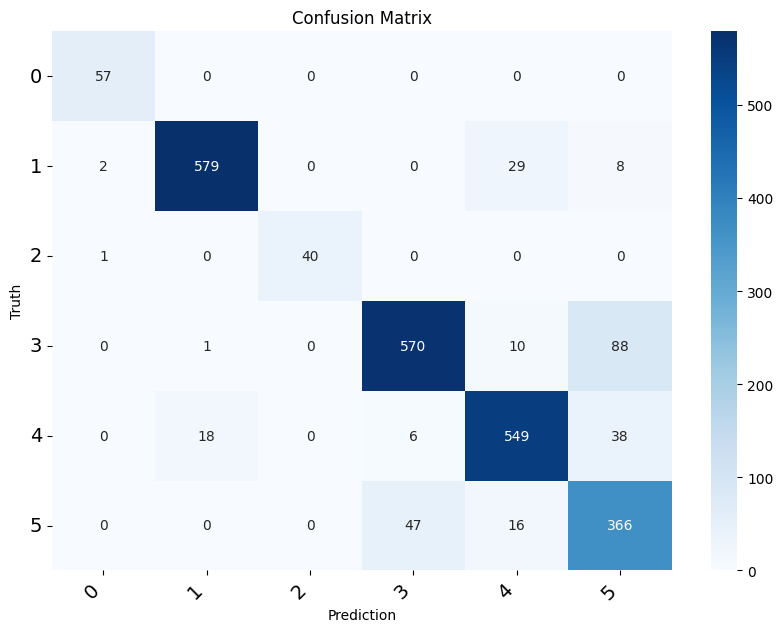

In [27]:
import pandas as pd
import seaborn as sns

# Make predictions on the test set
y_preds = model.predict(X_test)
y_preds = np.argmax(y_preds, axis=-1)  # Convert probabilities to class labels

# Check if y_test is one-hot encoded or not
if y_test.ndim > 1 and y_test.shape[1] > 1:  # Assuming one-hot encoding
    y_test = np.argmax(y_test, axis=-1)  # Convert to integer labels

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_preds)

# Class names (replace with your actual class names)
class_names = [str(i) for i in range(len(np.unique(y_test)))]

# Function to print confusion matrix as a heatmap
def print_confusion_matrix(confusion_matrix, class_names, figsize=(10, 7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap."""
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')  # Set a color map for better visualization
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
    plt.title('Confusion Matrix')
    plt.show()

# Print the confusion matrix
print_confusion_matrix(cm, class_names)